## Image classfication using ResNet model
#### Dataset: [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
#### Framework: Pytorch

In [2]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from random import randrange
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
%matplotlib inline

In [3]:
#defining the model to be used
# 4 CNN & 1 fully-connected layer with 2 residual blocks
class CustomModel(nn.Module):
    def __init__(self, f1):
        super().__init__()
        self.f1 = f1
        self.conv1 = self.conv_block(f1.input_channels, 64)
        self.conv2 = self.conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        
        self.conv3 = self.conv_block(128, 256, pool=True)
        self.conv4 = self.conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, f1.num_classes))
    
    def conv_block(self, in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = self.f1.accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [4]:
class DeviceDataLoader():
    def __init__(self, f1, dl, device):
        self.dl = dl
        self.device = device
        self.f1 = f1
        
    def __iter__(self):
        for b in self.dl: 
            yield self.f1.to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
    
    

In [5]:
class CNN():
    def __init__(self):
        print("constructor")
        
    #initialize hyperparameters
    def init_hyp(self):
        self.batch_size = 128
        self.lr = 0.001
        self.epoch = 25
        self.max_lr = 0.01
        self.grad_clip = 0.1
        self.weight_decay = 1e-4

    #get data in torch tensor
    def get_data(self):
        self.Dataset = CIFAR10
        train_tfms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
        
        self.dataset = self.Dataset(root='data/', train=True, transform=train_tfms, download=True)
        self.input_size = np.prod(self.dataset[0][0].shape)
        self.input_channels = self.dataset[0][0].shape[0]
        self.num_classes = len(self.dataset.classes)

    #initialize data & make torch tensors
    def init_data(self):
        self.get_data()
        self.init_hyp()
        self.model = CustomModel(self)
        self.device = self.get_default_device()
        self.to_device(self.model, self.device)
        
        train_ds, val_ds = random_split(self.dataset, [int(len(self.dataset)*0.8), int(len(self.dataset)*0.2)])
        self.test_ds = self.Dataset(root='data/', train=False, transform=transforms.ToTensor())

        self.train_loader_cpu = DataLoader(train_ds, self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_ds, self.batch_size*2)
        self.test_loader = DataLoader(self.test_ds, self.batch_size*2)
        
        self.train_loader = DeviceDataLoader(self, self.train_loader_cpu, self.device)
        self.val_loader = DeviceDataLoader(self, self.val_loader, self.device)
        self.test_loader = DeviceDataLoader(self, self.test_loader, self.device)
        
    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    @torch.no_grad()
    def evaluate(self, data):
        self.model.eval()
        outputs = [self.model.validation_step(batch) for batch in data]
        return self.model.validation_epoch_end(outputs)
    
    def display_batch(self):
        for images, _ in self.train_loader_cpu:
            print('images.shape:', images.shape)
            plt.figure(figsize=(16,8))
            plt.axis('off')
            plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
            break

    #train the model on train data
    def fit(self, opt_func=torch.optim.Adam):
        torch.cuda.empty_cache()
        self.history = []
        optimizer = opt_func(self.model.parameters(), self.lr)
        
        optimizer = opt_func(self.model.parameters(), self.max_lr, weight_decay=self.weight_decay)
        sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, self.max_lr, epochs=self.epoch, 
                                                steps_per_epoch=len(self.train_loader))
        for e in range(self.epoch):
            self.model.train()
            train_losses = []
            lrs = []
            for batch in self.train_loader:
                loss = self.model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                
                if self.grad_clip: 
                    nn.utils.clip_grad_value_(self.model.parameters(), self.grad_clip)
                
                optimizer.step()
                optimizer.zero_grad()                
                lrs.append(self.get_lr(optimizer))
                sched.step()

            result = self.evaluate(self.val_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            result['lrs'] = lrs
            self.model.epoch_end(e, result)
            self.history.append(result)
            
    def plot_acc(self):
        accuracies = [r['val_acc'] for r in self.history]
        plt.plot(accuracies, '-x')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('Accuracy vs. No. of epochs')
        
    def plot_loss(self):
        losses = [r['val_loss'] for r in self.history]
        plt.plot(losses, '-x')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Loss vs. No. of epochs');
        
    #predict random image from test dataset
    def predict_rand_image(self):
        img_i = randrange(0, len(self.test_ds), 1)
        img, label = self.test_ds[img_i]
        print(img.shape)
        plt.imshow(img.permute(1, 2, 0))
        print('Label:', self.test_ds.classes[label], ', Predicted:', self.test_ds.classes[self.predict_image(img)])
        
    def predict_image(self,img):
        xb = self.to_device(img.unsqueeze(0), self.device)
        yb = self.model(xb)
        _, preds  = torch.max(yb, dim=1)
        return preds[0].item()
    
    def get_default_device(self):
        if torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')
    
    def to_device(self, data, device):
        if isinstance(data, (list,tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def get_lr(self, optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']

In [6]:
f1 = CNN()

constructor


In [7]:
f1.init_data()

Files already downloaded and verified


In [8]:
f1.get_default_device()

device(type='cuda')

images.shape: torch.Size([128, 3, 32, 32])


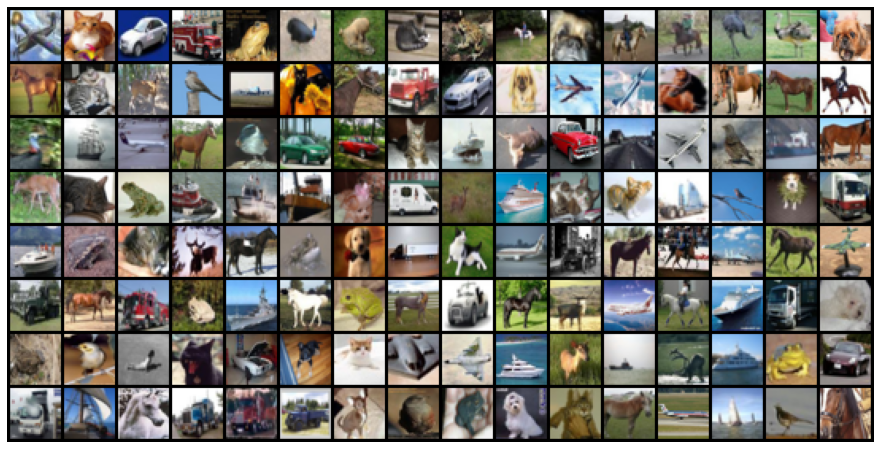

In [9]:
f1.display_batch()

In [10]:
f1.evaluate(f1.test_loader)

{'val_loss': 2.3035500049591064, 'val_acc': 0.10185547173023224}

In [11]:
f1.fit()

Epoch [0], val_loss: 1.1896, val_acc: 0.5784
Epoch [1], val_loss: 1.0342, val_acc: 0.6461
Epoch [2], val_loss: 1.0320, val_acc: 0.6731
Epoch [3], val_loss: 0.8173, val_acc: 0.7338
Epoch [4], val_loss: 0.7516, val_acc: 0.7439
Epoch [5], val_loss: 0.7412, val_acc: 0.7473
Epoch [6], val_loss: 0.9375, val_acc: 0.7218
Epoch [7], val_loss: 0.7236, val_acc: 0.7712
Epoch [8], val_loss: 0.6214, val_acc: 0.7920
Epoch [9], val_loss: 0.4861, val_acc: 0.8426
Epoch [10], val_loss: 0.6997, val_acc: 0.7882
Epoch [11], val_loss: 0.4633, val_acc: 0.8481
Epoch [12], val_loss: 0.5418, val_acc: 0.8316
Epoch [13], val_loss: 0.4422, val_acc: 0.8651
Epoch [14], val_loss: 0.3540, val_acc: 0.8866
Epoch [15], val_loss: 0.4067, val_acc: 0.8782
Epoch [16], val_loss: 0.3721, val_acc: 0.8880
Epoch [17], val_loss: 0.3851, val_acc: 0.8919
Epoch [18], val_loss: 0.3745, val_acc: 0.8964
Epoch [19], val_loss: 0.3507, val_acc: 0.9057
Epoch [20], val_loss: 0.3333, val_acc: 0.9108
Epoch [21], val_loss: 0.3233, val_acc: 0.914

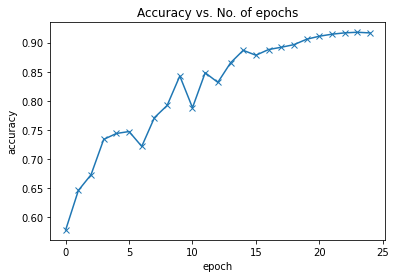

In [12]:
f1.plot_acc()

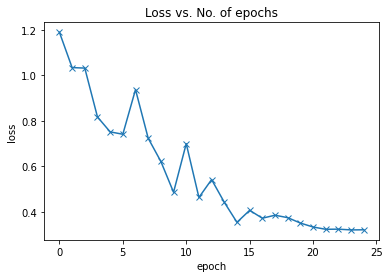

In [13]:
f1.plot_loss()

In [14]:
f1.evaluate(f1.test_loader)

{'val_loss': 0.35256391763687134, 'val_acc': 0.9095703363418579}

torch.Size([3, 32, 32])
Label: cat , Predicted: cat


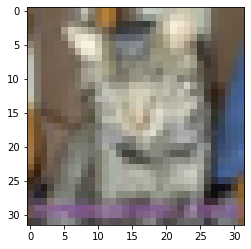

In [79]:
f1.predict_rand_image()

In [81]:
torch.save(f1.model.state_dict(), 'cifar10.pth')